# DNN: the Basics

In this notebook, we will learn the basics of a Deep Neural Network (DNN) based on [Pytorch](https://pytorch.org/), a Python based machine learning framework for building and training deep neural networks with strong GPU acceleration. 

We will use the `FashionMNIST` dataset, which is useful for quick examples when learning the basics. In [DNN_practical.ipynb](DNN_practical.ipynb), we will follow the same principles to practice with a more relevant scientific dataset. To understand how a DNN works, we will implement a fully connected DNN from scratch in [DNN_backprop.ipynb](DNN_backprop.ipynb), 

In [1]:
# helpers
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

---

# The Dataset and Dataloader

PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset from which samples are loaded. Dataloader supports automatic batching, sampling, shuffling and multiprocess data loading.

To start with, we will use the `FashionMNIST` dataset from TorchVision. Every TorchVision Dataset includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# print info
print("Number of training samples: %d" % len(training_data))
print("Number of test samples: %d" % len(test_data))

Number of training samples: 60000
Number of test samples: 10000


Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
from torch.utils.data import DataLoader

batch_size = 64

# Create dataloader to load the dataset during training
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Verify dataloader is working
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])


We can randomly plot some images and their labels:

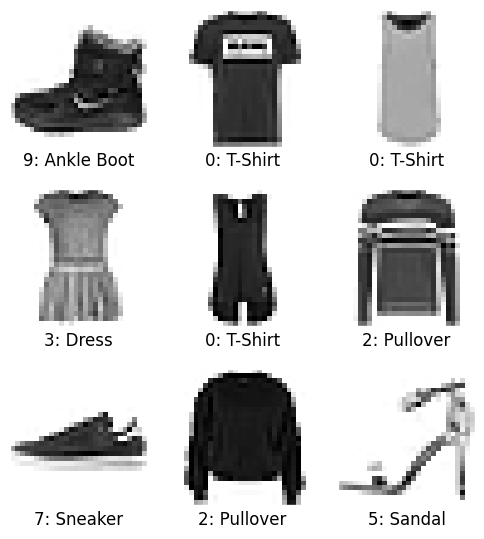

In [4]:
string_labels = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
ncols, nrows = 3, 3
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))

for iplot, idata in enumerate(np.random.choice(len(training_data), nrows * ncols)):
    img, label = training_data[iplot]
    label_str = "%d: %s" % (label, string_labels[label])
    subplot_image(img.squeeze(0), label_str, nrows, ncols, iplot)


---

# Classification by DNN

Here we will create and train a DNN model to classify the images in `FashionMNIST`. The task can be divided into three essential steps:

1. Build the neural network;
2. Optimize the network;

These steps may be repeated for a few times to improve the quality (accuracy and stability) of the model.

## 1. Build the network architecture

Our first DNN will be a simple multi-layer perceptron with only one hidden layer, as shown in the following figure:


![dense.jpeg](https://github.com/stfc-sciml/sciml-workshop/blob/master/course_3.0_with_solutions/markdown_pic/dnn.png?raw=1)

In general, a network of this kind should include an input layer, some hidden layers and an output layer. In this example, all the layers will be `Linear` layers with or without activation function. The linear layer is composed of neurons `W` and biases `b` (optional) and perform linear transformation on the input $x$, i.e. $y=xW^T+b$.


### The input layer

We first need to determine the dimensionality of the input layer. Since we are using `Linear` layers, we will flatten the input images before feeding them to the network. As the images are 28 $\times$ 28 in pixels, the flattened input size will be 784. The flattened input will be then passed to the input layer.

### The hidden layers

We use one hidden layer in this case and use `ReLU` as its activation function:

> $R(x)=\max(0,x)$

**NOTE**: Different activation functions are used for different tasks. Remember that `ReLU` generally performs well for training a network, but it can *only* be used in the input and hidden layers.


### The output layer

We usually encode categorical data as a "one-hot" vector. In this case, we have a vector of length 10 on the output side, where each element corresponds to a class of apparel. Ideally, we hope the values to be either 1 or 0, with 1 for the correct class and 0 for the others, so we use `sigmoid` as the activation function for the output layer:

> $S(x) = \dfrac{1}{1 + e^{-x}}$

In [6]:
from torch import nn
from torch.nn import functional as F

# build a neural network in Pytorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, output_dim=10, dropout=0.0):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.dropout = dropout
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.hidden_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.output_layer =  nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        print(x.shape)
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


### Create and compile the model

In [7]:
# Create the model
model = NeuralNetwork(input_dim=784)
# print(model)

# Compile the model using a dummy input with batch size 1
inputs = torch.rand((4, 1, 28, 28))
print('Inputs:', inputs.size())
outputs = model(inputs)
print('Outputs:', outputs.size())


Inputs: torch.Size([4, 1, 28, 28])
torch.Size([4, 784])
Outputs: torch.Size([4, 10])


To define a neural network in PyTorch, we create a class `NeuralNetwork` that inherits from Pytorch `nn.Module` which has functions implementing automatic differentiation. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. 

In the above network, first, we define a flatten layer with `nn.Flatten` module to converts the 2D input image to 1D contigious array. Note that the mini batch dimension (at dim=0) will be maintained by the operation. 

Similarly, we define our input, hidden and output layers. Neurons in each layer is realized using the `nn.Linear` module. We use `nn.ReLU` as activation function in the input and hidden layer, whereas `nn.Sigmoid` is used in the output layer. The module `nn.Sequential` allows us to put together the list of sub-modules e.g. the `nn.Layer` and `nn.ReLU` and pass the data through the modules in the same order as defined. We also add `Dropout` layer in the `input` and `hidden` layer for network regularization. 

Finally, to test the model, we define a dummy input of batch size 3 and place it in the same device as the network (Pytorch require the data and network to be resided on the same device). We pass the data by calling it with the input; `model(inputs)`. This executes the model’s forward, along with some background operations.

Calling the model on the input returns a 2-dimensional tensor with `dim=0` corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. An `argmax` operation is performed along class label dimension to estimate the class label. 


## 2. Optimize the network

To optimize the neural network, we will need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an [optimizer](https://pytorch.org/docs/stable/optim.html) 

### Loss

The loss is the objective function to be minimised during training. Gradients of the loss with respect to the model parameters, calculated by backpropagating the errors, determine the direction to update the model parameters. Follow [DNN_backprop.ipynb](DNN_backprop.ipynb) to learn the details about *backpropagation* and *gradient descent*. In this case, we will use `CrossEntropyLoss` as the loss function because we are dealing with 10 classes.  

### Optimizer

An optimiser is an algorithm determining how the model parameters are updated based on the loss. One critical hyperparameter for the optimiser is the *learning rate*, which determines the magnitude to update the model parameters (also see [DNN_backprop.ipynb](DNN_backprop.ipynb) for details). In many applications, *Adam* is usually a good choice at the beginning. We will use Adam in this example.


In [8]:
# define loss function
loss_fn = nn.CrossEntropyLoss()

# create a optimizer with constant learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

To create a loss function, we will use the modules provided inside [torch.nn](https://pytorch.org/docs/stable/nn.html) and initialize an instance of `CrossEntropyLoss`. Similarly, PyTorch provides a wide range of optimizers (see [torch.optim](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer)). We will use `Adam` optimizer for our example as it works well in most cases. The PyTorch optimizer accepts an iterable containing the parameters (all should be [Variable's](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter)) to optimize and the rate at which to update the parameters.

## 3. Train the Neural Network

Now we can start to train the model with `FashionMNIST` dataset. Before that, we need to understand the concepts of `epochs` and `mini-batch size`.

### Epochs

It is the number of times that the model will run through the entire dataset during training.

### Mini-batch size

It determines how many data will be used at a time to determine the gradient used for parameter update. Follow [DNN_backprop.ipynb](DNN_backprop.ipynb) to learn more about *Batch*, *Mini-batch* and *Stochastic Gradient Descent*.


### Training loop
Unlike Keras, PyTorch doesn't have a pre-defined training loop, so we will create a simple training loop. To train the neural network, usually, we will iterate over the dataset in mini-batches, pass the mini-batches to the network, calculate the loss, compute gradients by backprogating the errors and update the weights of the neural network.

In [ ]:
# for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# define a train function
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    
    train_loss, train_accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        # place tensors to device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred_y = model(X)

        # convert target class indices into one-hot encoding
        target_y = F.one_hot(y, 10).to(torch.float32)

        # compute loss
        loss = loss_fn(pred_y, target_y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_accuracy += (pred_y.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.detach().item()
    
    train_loss /= num_batches
    train_accuracy /= size
    
    return train_loss, train_accuracy

### Validation loop

To assess the network's performances in new and unseen data, we will use the validation dataset at the end of training. However, the validation of the network can be done at the middle of training that helps us identify under-fitting and over-fitting problem. To make predictions with a confidence equivalent to that for training, the accuracy for the validation data should not differ too much from that for the training data.

In [ ]:
# define a test function to evaluate the model
def test(dataloader, model, loss_fn, device):
    # set the model to eval mode
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # inference/prediction
            pred_y = model(X)

            # convert target class indices into one-hot encoding
            target_y = F.one_hot(y, 10).to(torch.float32)

            # compute test loss and accuracy
            test_loss += loss_fn(pred_y, target_y).item()
            test_accuracy += (pred_y.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_accuracy /= size

    return test_loss, test_accuracy

The training process is conducted over several iterations (epochs). During each epoch, entire samples is passed through the network and network's parameters are updated to make better predictions. At the end of each epoch, it is better to compute the accuracy on the test dataset to evaluate the generalizabilty of the network in unseen data. We will create a simple `trainer` function that does this function. We will also record the loss and accuracy obtained during each epoch for analysis and visualizations. 

In [ ]:
def trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    start = time.time()
    h = dict(train_loss=[], test_loss=[], train_accuracy=[], test_accuracy=[])
    for t in range(epochs):
        print(f"\nEpoch {t+1}/{epochs}: ", end='')
        
        train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer, device)

        test_loss, test_accuracy = test(test_dataloader, model, loss_fn, device)
        print(f"train_loss: {train_loss:0.3f}, train_accuracy: {(100*train_accuracy):0.2f}%, test_accuracy: {(100*test_accuracy):0.2f}%")

        # print(f"Test Accuracy: {(100*test_accuracy):0.2f}%, Test Loss: {test_loss:0.3f}")

        h['train_loss'].append(train_loss)
        h['test_loss'].append(test_loss)
        h['train_accuracy'].append(train_accuracy)
        h['test_accuracy'].append(test_accuracy)

    print(f"Done in {time.time()-start:.3f}secs!")
    
    return h

Let`s train the network!!

In [ ]:
epochs = 20
history = trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device)

### Check training history

We can examine the training history by plotting accuracy and loss against epoch for both the training and the test data. 

Notice that the accuracies for the training and the test data diverge as the model trains (after around epoch 50). This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.


In [ ]:
# plot accuracy
def plot_history(history, figsize=(12, 4)):
    plt.close('all')
    plt.figure(dpi=100, figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'], label='Train')
    plt.plot(history['test_accuracy'], label='Test')
    plt.legend()
    plt.title("Accuracy")
    
    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['test_loss'], label='Test')
    plt.legend()
    plt.title("Loss")
    plt.show()
    
plot_history(history)

### Finding the best epoch for early-stopping
The test accuracy at the end of the training may not always represent the optimal value because the network can reach the peak accuracy even before the final epoch. It is good idea to identify such point and stop the training because training beyond this point doesn't improve the test accuracy. This strategy is also known as early-stopping and is widely used to minimize the training time. 

In [ ]:
print(f"Best train accuracy: {np.max(history['train_accuracy']):0.2f} at epoch {np.argmax(history['train_accuracy'])}")
print(f"Best test accuracy: {np.max(history['test_accuracy']):0.2f} at epoch {np.argmax(history['test_accuracy'])}")

### Hyperparameter Tunning

There are several factors affecting the prediction accuracy e.g. model complexity, learning rate, batch size and so on. We will need to address each factor step-by-step. For instance, we can decrease the model complexity by reducing the `hidden_dim` by half and re-run the experiment.

In [ ]:
model = NeuralNetwork(hidden_dim=128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
history =  trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs)
plot_history(history)

## 4. Regularisation
 
Regularisation of the network helps to mitigate the overfitting and gradient exploding problem. Dropout, also called dilution, is a popular regularisation technique which randomly omit a certain amount of neurons from a layer with probability `p`. Here we will rebuild our model with `Dropout` layer between the hidden and the output layers. Let us see whether this can negate the overfitting or not. 

In [ ]:
batch_size = 256
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

model = NeuralNetwork(hidden_dim=128, dropout=0.2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
history =  trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs)

In [ ]:
plot_history(history)
print(f"Best train accuracy: {np.max(history['train_accuracy']):0.2f}")
print(f"Best test accuracy: {np.max(history['test_accuracy']):0.2f}")

## 5. Make predictions/inference

Finally, we can use our trained model to make predictions. Here we show some wrong predictions for the test data, from which we may get some ideas about what kinds of images baffle our model.

In [ ]:
# use test images to make predictions
def predict(dataloader, model):
    # set the model to eval mode
    model.eval()
    
    gt_images, gt_labels, pred_labels = [], [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            # inference/prediction
            pred_y = model(X.to(device)).cpu().numpy()

            gt_images.append(X.numpy())
            gt_labels.append(y.numpy())
            pred_labels.append(pred_y.argmax(1))

    gt_images = np.concatenate(gt_images)
    gt_labels = np.concatenate(gt_labels)
    pred_labels = np.concatenate(pred_labels)
    
    return gt_images, gt_labels, pred_labels


In [ ]:
test_images, test_labels, pred_labels = predict(test_dataloader, model)

# get the indices of wrong predictions
id_wrong = np.where(pred_labels != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_labels[idata], string_labels[pred_labels[idata]])
    subplot_image(test_images[idata].squeeze(), label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

## Exercises

* Change some hyperparameters like `hidden_dim`, `dropout` in the `NeuralNetwork` to see their effects.  
* Use two hidden layers respectively with sizes 256 and 64, and see whether the accuracy can be improved or not;
* Change the output from 0-1 binary to probability, i.e., the one-hot vector represents the probabilities that an image belongs to the classes; this can be achieved by 1) replacing the `nn.Sigmoid()` in the output layer with a `nn.Softmax()`.
* Double the batch size and learning rate
* Change the optimizer to `AdamW` (see other [optmizers](https://pytorch.org/docs/stable/optim.html)) with or without weight regularization 